In [5]:
try:
  import distrax
except ModuleNotFoundError:
  %pip install distrax
  import distrax
try:
  import jax
except ModuleNotFoundError:
  %pip install jax 
  import jax

import jax.numpy as jnp
try:
  import matplotlib.pyplot as plt
except ModuleNotFoundError:
  %pip install matplotlib 
  import matplotlib.pyplot as plt

key = jax.random.PRNGKey(42)
jax.config.update("jax_enable_x64", True)

try:
  import GPy
except ModuleNotFoundError:
  %pip install GPy
  import GPy

try:
  from tqdm import tqdm
except ModuleNotFoundError:
  %pip install tqdm
  from tqdm import tqdm


try: 
  import jaxopt
except ModuleNotFoundError:
  %pip install jaxopt
  import jaxopt

import optax
from sklearn.neighbors import NearestNeighbors
import numpy as np
import pandas as pd

In [6]:
def rbf(x, x_star, len_scale_, varf_):
  sqdist = jnp.sum(x**2,1).reshape(-1,1) + jnp.sum(x_star**2,1) - 2*jnp.dot(x, x_star.T)
  return varf_*jnp.exp(-.5 * (1/len_scale_) * sqdist)

def NLL(theta,x,y):
  len_scale_ = jnp.exp(theta["log_scale"])
  varf_ = jnp.exp(theta["log_varf"])
  k = rbf(x,x,len_scale_, varf_)
  k = k + ( jnp.exp(theta["log_vary"]) * jnp.eye(len(x)))
  mean_vec= jnp.zeros(y.shape[0])
  dist = distrax.MultivariateNormalFullCovariance(mean_vec, k)
  dist_logprob = dist.log_prob(y.reshape(-1,))
 
  return -dist_logprob

In [7]:
def SGD(x, y, theta, batch_size, alpha, epochs):
  nll_epoch = []
  nll_grad = []
  theta1 = theta
  lr = alpha
  nll_gradient = jax.jit(jax.grad(NLL, argnums = 0))

  
  if (len(x) % batch_size  == 0):
    num_batches = int(len(x)/batch_size)
  else:
    num_batches = int((len(x)/batch_size)) + 1

  
  tx = optax.adam(lr)
  neigh = NearestNeighbors(n_neighbors=batch_size, algorithm='kd_tree')
  neigh.fit(x)
  _,neigh_idx = neigh.kneighbors(x, batch_size)
    
  for i in range(epochs):
    
    ## use tfds for shuffling
    batch_index = 0
    X_, Y_ = jax.random.shuffle(key_, x), jax.random.shuffle(key, y)

  
    for k in range(num_batches):
      opt_state1 = tx.init((theta1["log_scale"]))
      opt_state2 = tx.init((theta1["log_varf"]))
      opt_state3 = tx.init((theta1["log_vary"]))

      ## Random batches
      # if batch_index+batch_size > len(X_):
      #    X_batch, Y_batch = X_[batch_index:,:], Y_[batch_index:,:]
      # else:
      #   X_batch, Y_batch = X_[batch_index:batch_index+batch_size,:], Y_[batch_index:batch_index+batch_size,:]
      
      ## NN batches
      center_idx  = jax.random.randint(key_,(1,), 1, len(y))
      nn_batch_indices =  neigh_idx[center_idx,]
      nn_batch_X  = X[nn_batch_indices,].reshape(-1,1)
      nn_batch_y  = Y[nn_batch_indices].reshape(-1,1)

      # grads = nll_gradient(theta1, X_batch, Y_batch)
      grads = nll_gradient(theta1,  nn_batch_X,  nn_batch_y)


      nll_grad.append(2*jnp.log(jnp.linalg.norm(jnp.array([grads["log_varf"],grads["log_vary"]]), ord=2)))
      # updates1,opt_state1 = tx.update(grads["log_scale"], opt_state1)
      # theta1["log_scale"] = optax.apply_updates((theta1["log_scale"]), updates1)
      updates2,opt_state2 = tx.update(((batch_size*grads["log_varf"])/(3*jnp.log(batch_size))), opt_state2)
      theta1["log_varf"] = optax.apply_updates((theta1["log_varf"]), updates2)
      updates3,opt_state3 = tx.update(grads["log_vary"], opt_state3)
      theta1["log_vary"] = optax.apply_updates((theta1["log_vary"]), updates3)

      nll_epoch.append(NLL(theta1,X_, Y_))

      # lr = lr/(k+1)


  print(NLL(theta1,X_, Y_))
  print(jnp.exp(theta1["log_scale"]), jnp.exp(theta1["log_varf"]), jnp.exp(theta1["log_vary"]))

  return nll_epoch, nll_grad


 10%|█         | 1/10 [01:50<16:36, 110.71s/it]

3374.8667305160566
0.5 328300071.1242696 3.000002892775352


 /home/userass/anaconda3/envs/DeepGP/lib/python3.10/site-packages/jax/_src/random.py:372: FutureWarning:jax.random.shuffle is deprecated and will be removed in a future release. Use jax.random.permutation with independent=True.
 20%|██        | 2/10 [03:09<12:17, 92.21s/it] 

2558.6704762131826
0.5 5.000017395575861 3.00000233352998


 /home/userass/anaconda3/envs/DeepGP/lib/python3.10/site-packages/jax/_src/random.py:372: FutureWarning:jax.random.shuffle is deprecated and will be removed in a future release. Use jax.random.permutation with independent=True.
 30%|███       | 3/10 [04:59<11:41, 100.16s/it]

2084.1664069659028
0.5 5.0000177984088685 3.0000022857024784


 /home/userass/anaconda3/envs/DeepGP/lib/python3.10/site-packages/jax/_src/random.py:372: FutureWarning:jax.random.shuffle is deprecated and will be removed in a future release. Use jax.random.permutation with independent=True.
 40%|████      | 4/10 [06:55<10:37, 106.24s/it]

2733.9515850631115
0.5 328300212.1517931 3.0000028817983835


 /home/userass/anaconda3/envs/DeepGP/lib/python3.10/site-packages/jax/_src/random.py:372: FutureWarning:jax.random.shuffle is deprecated and will be removed in a future release. Use jax.random.permutation with independent=True.
 50%|█████     | 5/10 [08:58<09:21, 112.32s/it]

2888.3782515089415
0.5 328300149.270287 3.000002778052543


 /home/userass/anaconda3/envs/DeepGP/lib/python3.10/site-packages/jax/_src/random.py:372: FutureWarning:jax.random.shuffle is deprecated and will be removed in a future release. Use jax.random.permutation with independent=True.
 60%|██████    | 6/10 [10:08<06:31, 97.88s/it] 

2421.6552221719576
0.5 5.000015319034816 3.0000024950972697


 /home/userass/anaconda3/envs/DeepGP/lib/python3.10/site-packages/jax/_src/random.py:372: FutureWarning:jax.random.shuffle is deprecated and will be removed in a future release. Use jax.random.permutation with independent=True.
 70%|███████   | 7/10 [11:11<04:20, 86.77s/it]

2856.597745313764
0.5 328298762.8259116 3.0000027326545866


 /home/userass/anaconda3/envs/DeepGP/lib/python3.10/site-packages/jax/_src/random.py:372: FutureWarning:jax.random.shuffle is deprecated and will be removed in a future release. Use jax.random.permutation with independent=True.
 80%|████████  | 8/10 [12:07<02:33, 76.94s/it]

2227.840580481402
0.5 5.000036815420074 3.000002727257267


 /home/userass/anaconda3/envs/DeepGP/lib/python3.10/site-packages/jax/_src/random.py:372: FutureWarning:jax.random.shuffle is deprecated and will be removed in a future release. Use jax.random.permutation with independent=True.
 90%|█████████ | 9/10 [12:51<01:06, 66.41s/it]

2817.7751436883027
0.5 328300124.50776756 3.0000026234598782


 /home/userass/anaconda3/envs/DeepGP/lib/python3.10/site-packages/jax/_src/random.py:372: FutureWarning:jax.random.shuffle is deprecated and will be removed in a future release. Use jax.random.permutation with independent=True.
100%|██████████| 10/10 [14:14<00:00, 85.47s/it]

2593.583979756573
0.5 5.000017513160889 3.0000024783241126



 10%|█         | 1/10 [01:54<17:11, 114.65s/it]

3374.8650848348966
0.5 328301114.1559144 3.000010072110068


 /home/userass/anaconda3/envs/DeepGP/lib/python3.10/site-packages/jax/_src/random.py:372: FutureWarning:jax.random.shuffle is deprecated and will be removed in a future release. Use jax.random.permutation with independent=True.
 20%|██        | 2/10 [04:11<17:01, 127.65s/it]

2558.6693405826545
0.5 5.000089031770003 3.000010282144494


 /home/userass/anaconda3/envs/DeepGP/lib/python3.10/site-packages/jax/_src/random.py:372: FutureWarning:jax.random.shuffle is deprecated and will be removed in a future release. Use jax.random.permutation with independent=True.
 30%|███       | 3/10 [06:02<14:01, 120.19s/it]

2084.1665346635455
0.5 5.000082190553892 3.000009229163578


 /home/userass/anaconda3/envs/DeepGP/lib/python3.10/site-packages/jax/_src/random.py:372: FutureWarning:jax.random.shuffle is deprecated and will be removed in a future release. Use jax.random.permutation with independent=True.
 40%|████      | 4/10 [08:06<12:10, 121.80s/it]

2733.951221794359
0.5 328300137.856743 3.0000115841759816


 /home/userass/anaconda3/envs/DeepGP/lib/python3.10/site-packages/jax/_src/random.py:372: FutureWarning:jax.random.shuffle is deprecated and will be removed in a future release. Use jax.random.permutation with independent=True.
 50%|█████     | 5/10 [09:41<09:19, 111.89s/it]

2888.3774277192724
0.5 328301352.58555776 3.000012449634308


 /home/userass/anaconda3/envs/DeepGP/lib/python3.10/site-packages/jax/_src/random.py:372: FutureWarning:jax.random.shuffle is deprecated and will be removed in a future release. Use jax.random.permutation with independent=True.
 60%|██████    | 6/10 [11:21<07:11, 107.87s/it]

2421.6544562472163
0.5 5.000075906432183 3.0000102517910703


 /home/userass/anaconda3/envs/DeepGP/lib/python3.10/site-packages/jax/_src/random.py:372: FutureWarning:jax.random.shuffle is deprecated and will be removed in a future release. Use jax.random.permutation with independent=True.
 70%|███████   | 7/10 [12:53<05:07, 102.61s/it]

2272.6446049848864
0.5 5.000175001095661 3.0000105653218347


 /home/userass/anaconda3/envs/DeepGP/lib/python3.10/site-packages/jax/_src/random.py:372: FutureWarning:jax.random.shuffle is deprecated and will be removed in a future release. Use jax.random.permutation with independent=True.
 80%|████████  | 8/10 [15:41<04:06, 123.47s/it]

2227.840507547892
0.5 5.000221109398419 3.0000121450074757


 /home/userass/anaconda3/envs/DeepGP/lib/python3.10/site-packages/jax/_src/random.py:372: FutureWarning:jax.random.shuffle is deprecated and will be removed in a future release. Use jax.random.permutation with independent=True.
 90%|█████████ | 9/10 [17:28<01:58, 118.53s/it]

2817.774668142243
0.5 328301192.94449574 3.000012096507265


 /home/userass/anaconda3/envs/DeepGP/lib/python3.10/site-packages/jax/_src/random.py:372: FutureWarning:jax.random.shuffle is deprecated and will be removed in a future release. Use jax.random.permutation with independent=True.
100%|██████████| 10/10 [19:06<00:00, 114.63s/it]

2593.5829918824898
0.5 5.000079751820921 3.000008999508755



 10%|█         | 1/10 [03:10<28:36, 190.70s/it]

3374.856515074001
0.5 328305536.3873591 3.0000464822002066


 /home/userass/anaconda3/envs/DeepGP/lib/python3.10/site-packages/jax/_src/random.py:372: FutureWarning:jax.random.shuffle is deprecated and will be removed in a future release. Use jax.random.permutation with independent=True.
 20%|██        | 2/10 [06:06<24:15, 181.97s/it]

2558.6650637713474
0.5 5.000535274644621 3.0000429490960303


 /home/userass/anaconda3/envs/DeepGP/lib/python3.10/site-packages/jax/_src/random.py:372: FutureWarning:jax.random.shuffle is deprecated and will be removed in a future release. Use jax.random.permutation with independent=True.
 30%|███       | 3/10 [09:00<20:47, 178.26s/it]

2084.1670680134666
0.5 5.00034349991375 3.000035454953396


 /home/userass/anaconda3/envs/DeepGP/lib/python3.10/site-packages/jax/_src/random.py:372: FutureWarning:jax.random.shuffle is deprecated and will be removed in a future release. Use jax.random.permutation with independent=True.
 40%|████      | 4/10 [11:59<17:51, 178.63s/it]

2175.716175489045
0.5 5.001479323840339 3.0000470152315253


 /home/userass/anaconda3/envs/DeepGP/lib/python3.10/site-packages/jax/_src/random.py:372: FutureWarning:jax.random.shuffle is deprecated and will be removed in a future release. Use jax.random.permutation with independent=True.
 50%|█████     | 5/10 [14:49<14:37, 175.44s/it]

2363.2327714532053
0.5 5.000088727160153 3.0000520713119605


 /home/userass/anaconda3/envs/DeepGP/lib/python3.10/site-packages/jax/_src/random.py:372: FutureWarning:jax.random.shuffle is deprecated and will be removed in a future release. Use jax.random.permutation with independent=True.
 60%|██████    | 6/10 [17:38<11:32, 173.14s/it]

2421.6511153666447
0.5 5.0003471619061335 3.0000442508422136


 /home/userass/anaconda3/envs/DeepGP/lib/python3.10/site-packages/jax/_src/random.py:372: FutureWarning:jax.random.shuffle is deprecated and will be removed in a future release. Use jax.random.permutation with independent=True.
 70%|███████   | 7/10 [20:35<08:43, 174.51s/it]

2272.6434281572606
0.5 5.000335185737585 3.0000332463116703


 /home/userass/anaconda3/envs/DeepGP/lib/python3.10/site-packages/jax/_src/random.py:372: FutureWarning:jax.random.shuffle is deprecated and will be removed in a future release. Use jax.random.permutation with independent=True.
 80%|████████  | 8/10 [24:13<06:16, 188.42s/it]

2227.889579841407
0.5 5.021007038979133 3.00004940948032


 /home/userass/anaconda3/envs/DeepGP/lib/python3.10/site-packages/jax/_src/random.py:372: FutureWarning:jax.random.shuffle is deprecated and will be removed in a future release. Use jax.random.permutation with independent=True.
 90%|█████████ | 9/10 [27:08<03:04, 184.14s/it]

2817.772466746769
0.5 328305723.54740024 3.000053360457389


 /home/userass/anaconda3/envs/DeepGP/lib/python3.10/site-packages/jax/_src/random.py:372: FutureWarning:jax.random.shuffle is deprecated and will be removed in a future release. Use jax.random.permutation with independent=True.
100%|██████████| 10/10 [30:33<00:00, 183.33s/it]

2593.5789755986816
0.5 5.00035897414423 3.000035919613483


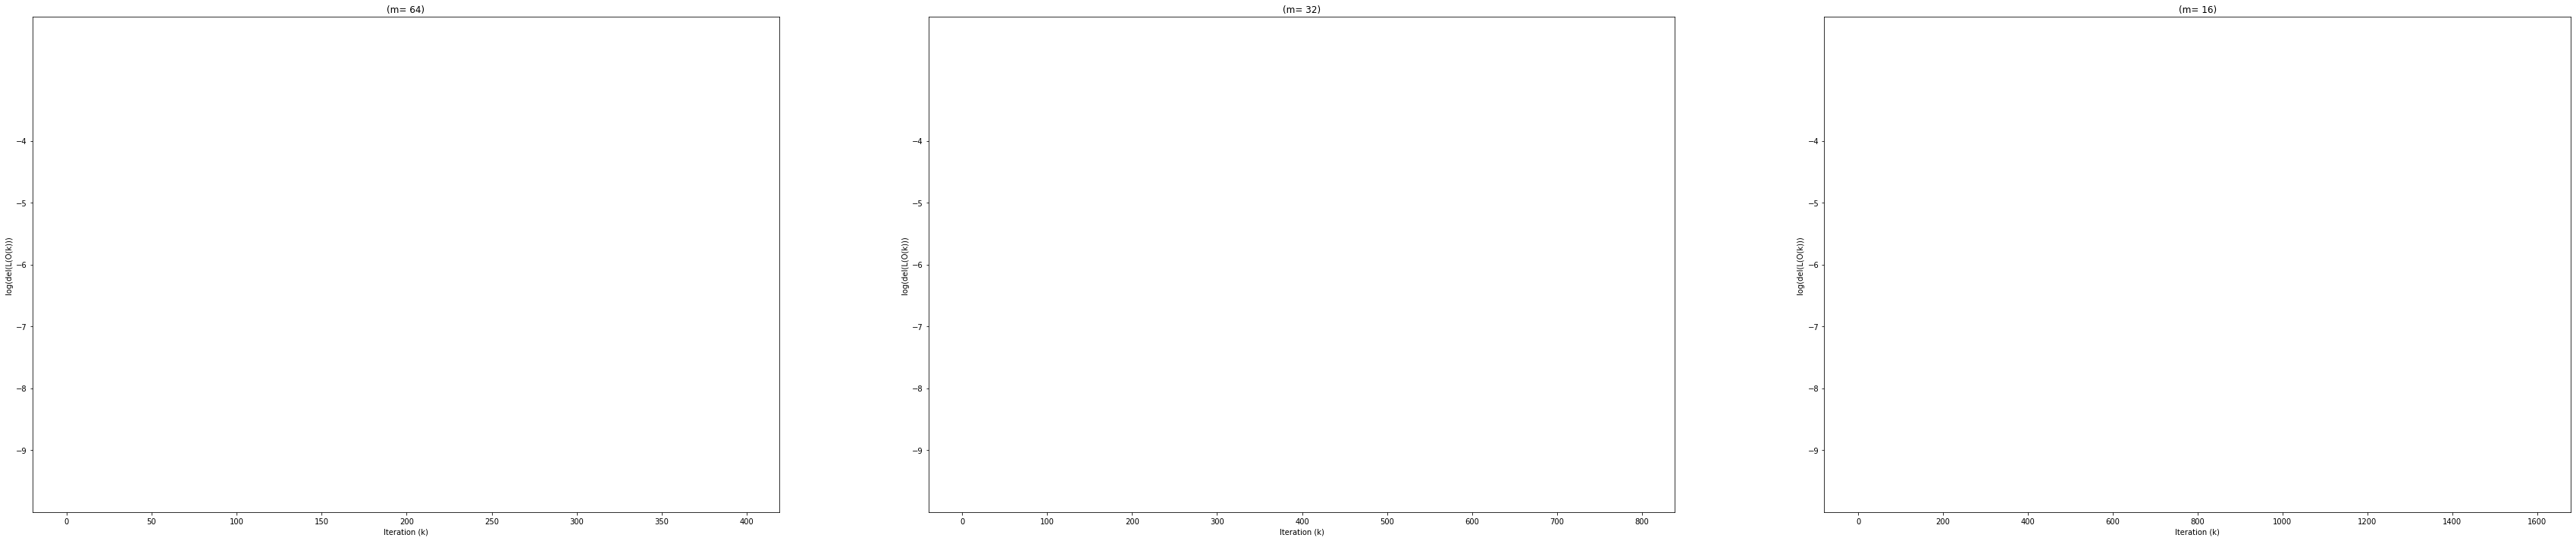

In [14]:
batch_sizes = [64,32,16]
N = 1024
alpha_arr = 9

fig,ax = plt.subplots(1,3,figsize=(60,12))

seed = np.random.randint(100, size=10)

for  j in range(3):
  gradient = []
  for t in tqdm(range(10)):
    theta_init = {"log_varf": jnp.log(5.),"log_vary": jnp.log(3.),"log_scale": jnp.log(0.5)}
    theta_ = theta_init
    alpha_ = alpha_arr

    key_ = jax.random.PRNGKey(seed[t])

    X_dist = distrax.Normal(0.0,5.0)
    X = X_dist.sample(seed=key_, sample_shape = (1024,)).reshape(-1,1)
    # print(X.shape)

    varf = 4.0
    len_scale = 0.5
    vary = 1.0

    cov = rbf(X, X, len_scale,  varf)  +   vary * jnp.eye(len(X))
    mean_vec = jnp.zeros(1024,)
    Y_dist = distrax.MultivariateNormalFullCovariance(mean_vec, cov)
    Y = Y_dist.sample(seed=key).reshape(-1,1)
    # print(Y.shape)

    loss, l2_grad = SGD(X, Y, theta_, batch_sizes[j], alpha_, 25)
    gradient.append(l2_grad)

  std = jnp.std(jnp.array(gradient), axis=0)
  mean = jnp.mean(jnp.array(gradient), axis=0)
  mean_s = pd.Series(mean).rolling(5).mean()[5:]
  std_s = pd.Series(std).rolling(5).mean()[5:]
  ax[j].plot(mean_s, 'b')
  ax[j].fill_between(range(len(mean_s)),mean_s-std_s, mean_s+std_s, alpha=0.5)
  ax[j].set_xlabel('Iteration (k)')
  ax[j].set_ylabel('log(del(L(O(k)))')
  ax[j].set_title(f'(m= {batch_sizes[j]})')
  ax[j].set_yticks([-4,-5,-6,-7,-8,-9])
  ax[j].set_ylim([-10,-2])

plt.savefig('figure2.png')